in this file a potenitla api is developed for the tramdag 

## TRAM Config

In [27]:
from utils.configuration import *

class TramDagConfig:
    def __init__(self, conf_dict: dict = None, CONF_DICT_PATH: str = None, **kwargs):
        """
        Initialize TramDagConfig.

        Args:
            conf_dict: optional dict with configuration. If None, starts empty.
            CONF_DICT_PATH: optional path to config file.
        """
        #TODO add verbose and debug , vebose print only infos, debug prints info + debug statements, warnings, errors are always printed
        #TODO add veryfier such that nothing is missing for later training such as experiment name 
        
        self.debug = False
        self.verbose = False
        
        for key, value in kwargs.items():
            if key in ['conf_dict', 'CONF_DICT_PATH']:
                raise ValueError(f"Cannot override '{key}' via kwargs.")
            setattr(self, key, value)
        
        self.conf_dict = conf_dict or {}
        self.CONF_DICT_PATH = CONF_DICT_PATH
        
        # verification 
        self._verify_completeness()

    @classmethod
    def load(cls, CONF_DICT_PATH: str,debug: bool = False):
        """
        Alternative constructor: load config directly from a file.
        """
        conf = load_configuration_dict(CONF_DICT_PATH)
        return cls(conf, CONF_DICT_PATH=CONF_DICT_PATH,debug=debug)

    def save(self, CONF_DICT_PATH: str = None):
        """
        Save config to file. If path is not provided, fall back to stored path.
        """
        path = CONF_DICT_PATH or self.CONF_DICT_PATH
        if path is None:
            raise ValueError("No CONF_DICT_PATH provided to save config.")
        write_configuration_dict(self.conf_dict, path)


    def _verify_completeness(self):
        """
        Verify that the configuration is complete and consistent:
        - All mandatory keys exist
        - Mandatory keys have valid values
        - Optional keys (if present) are valid
        """
        mandatory_keys = ["experiment_name","PATHS", "nodes", "data_type", "adj_matrix","nodes","model_names"]
        optional_keys = ["date_of_creation", "seed"]

        # ---- 1. Check mandatory keys exist
        missing = [k for k in mandatory_keys if k not in self.conf_dict]
        if missing:
            print(f"[WARNING] Missing mandatory keys in configuration: {missing}"
                "\n Please add them to the configuration dict and reload.")
            
        # --- 2. Check  if mandatory keys in nodesdict are present
        mandatory_keys_nodes = ['data_type', 'node_type','parents','parents_datatype','transformation_terms_in_h()','transformation_term_nn_models_in_h()']
        optional_keys_nodes = ["levels"]
        for node, node_dict in self.conf_dict.get("nodes", {}).items():
            # check missing mandatory keys
            missing_node_keys = [k for k in mandatory_keys_nodes if k not in node_dict]
            if missing_node_keys:
                print(f"[WARNING] Node '{node}' is missing mandatory keys: {missing_node_keys}")
                

        
        if self._verify_levels_dict():
            if self.debug:
                print("[DEBUG] levels are present for all ordinal variables in configuration dict.")
            pass
        else:
            print("[WARNING] levels are missing for some ordinal variables in configuration dict. THIS will FAIL in model training later!\n"
                " Please provide levels manually to config and reload or compute levels from data using the method compute_levels().\n"
                " e.g. cfg.compute_levels(train_df) # computes levels from training data and writes to cfg")

        if self._verify_experiment_name():
            if self.debug:
                print("[DEBUG] experiment_name is valid in configuration dict.")
            pass
        
        if self._verify_adj_matrix():
            if self.debug:
                print("[DEBUG] adj_matrix is valid in configuration dict.")
            pass

    def _verify_levels_dict(self):
        """
        Verify that levels_dict is present for all categorical variables.
        """
        data_type = self.conf_dict.get('data_type', {})
        nodes = self.conf_dict.get('nodes', {})
        for var, dtype in data_type.items():
            if 'ordinal' in dtype:
                if var not in nodes or 'levels' not in nodes[var]:
                    return False
        return True

    def _verify_experiment_name(self):
        experiment_name = self.conf_dict.get("experiment_name")
        if experiment_name is None or str(experiment_name).strip() == "":
            return False
        return True
        
    def _verify_adj_matrix(self):
        adj_matrix = self.conf_dict['adj_matrix']
        if isinstance(adj_matrix, list):
            adj_matrix = np.array(self.conf_dict['adj_matrix'])
        if validate_adj_matrix(adj_matrix):
            return True
        else:
            return False
        
    def compute_levels(self, df: pd.DataFrame, write: bool = True):
        """
        Derive levels information from data and update configuration dict.
        """
        levels_dict = create_levels_dict(df, self.conf_dict['data_type'])
        
        # update nodes dict with levels
        for var, levels in levels_dict.items():
            if var in self.conf_dict['nodes']:
                self.conf_dict['nodes'][var]['levels'] = levels
            else:
                print(f"[WARNING] Variable '{var}' not found in nodes dict. Cannot add levels.")
        
        if write and self.CONF_DICT_PATH is not None:
            try:
                self.save(self.CONF_DICT_PATH)
                if self.verbose or self.debug:
                    print(f'[INFO] Configuration with updated levels saved to {self.CONF_DICT_PATH}')
            except Exception as e:
                print(f'[ERROR] Failed to save configuration: {e}')

    def plot_dag(self, seed: int = 42, use_spring: bool = True):
        """
        Plot the DAG with Source, Sink, and Intermediate nodes.

        Parameters
        ----------
        seed : int, default=42
            Random seed for layout stability.
        use_spring : bool, default=True
            If True use networkx.spring_layout; 
            if False try Graphviz “dot” (falls back to spring).
        """
        adj_matrix = self.conf_dict.get("adj_matrix")
        data_type  = self.conf_dict.get("data_type")

        if adj_matrix is None or data_type is None:
            raise ValueError("Configuration must include 'adj_matrix' and 'data_type'.")

        # convert list to numpy if needed
        if isinstance(adj_matrix, list):
            adj_matrix = np.array(adj_matrix)

        if not validate_adj_matrix(adj_matrix):
            raise ValueError("Invalid adjacency matrix.")
        if len(data_type) != adj_matrix.shape[0]:
            raise ValueError("data_type must match adjacency matrix size.")

        node_labels = list(data_type.keys())
        G, edge_labels = create_nx_graph(adj_matrix, node_labels)

        # classify nodes
        sources       = {n for n in G.nodes if G.in_degree(n) == 0}
        sinks         = {n for n in G.nodes if G.out_degree(n) == 0}
        intermediates = set(G.nodes) - sources - sinks

        # assign node colors
        node_colors = [
            "green" if n in sources
            else "red" if n in sinks
            else "lightblue"
            for n in G.nodes
        ]

        # choose layout
        if use_spring:
            pos = nx.spring_layout(G, seed=seed, k=1.5, iterations=100)
        else:
            try:
                pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
            except (ImportError, nx.NetworkXException):
                pos = nx.spring_layout(G, seed=seed, k=1.5, iterations=100)

        # draw nodes and edges
        plt.figure(figsize=(8, 6))
        nx.draw(
            G, pos,
            with_labels=True,
            node_color=node_colors,
            edge_color="gray",
            node_size=2500,
            arrowsize=20
        )

        # draw edge labels colored by prefix
        for (u, v), lbl in edge_labels.items():
            color = (
                "blue"  if lbl.startswith("ci")
                else "red"   if lbl.startswith("ls")
                else "green" if lbl.startswith("cs")
                else "black"
            )
            nx.draw_networkx_edge_labels(
                G, pos,
                edge_labels={(u, v): lbl},
                font_color=color,
                font_size=12
            )

        # build legend
        legend_items = [
            Patch(facecolor="green",     edgecolor="black", label="Source"),
            Patch(facecolor="red",       edgecolor="black", label="Sink"),
            Patch(facecolor="lightblue", edgecolor="black", label="Intermediate")
        ]
        plt.legend(handles=legend_items, loc="upper right", frameon=True)

        plt.title("TRAM DAG")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # def compute_scaling(self, df: pd.DataFrame, write: bool = True):
    #     """
    #     Derive scaling information (min, max, levels) from data USE training data.
    #     """
    #     print("[INFO] Make sure to provide only training data to compute_scaling!")
    #     # calculate 5% and 95% quantiles for min and max values
    #     quantiles = df.quantile([0.05, 0.95])
    #     min_vals = quantiles.loc[0.05]
    #     max_vals = quantiles.loc[0.95]

    #     # calculate levels for categorical variables
    #     levels_dict = create_levels_dict(df, self.conf_dict['data_type'])

    #     # TODO remove outer dependency of these functions (re-loading conf dict)
    #     adj_matrix = read_adj_matrix_from_configuration(self.CONF_DICT_PATH)
    #     nn_names_matrix = read_nn_names_matrix_from_configuration(self.CONF_DICT_PATH)

    #     node_dict = create_node_dict(
    #         adj_matrix,
    #         nn_names_matrix,
    #         self.conf_dict['data_type'],
    #         min_vals=min_vals,
    #         max_vals=max_vals,
    #         levels_dict=levels_dict
    #     )
    #     conf_dict = load_configuration_dict(self.CONF_DICT_PATH)
    #     conf_dict['nodes'] = node_dict
    #     self.conf_dict = conf_dict  # keep it in memory too

    #     if write and self.CONF_DICT_PATH is not None:
    #         try:
    #             write_configuration_dict(conf_dict, self.CONF_DICT_PATH)
    #             print(f'[INFO] Configuration with updated scaling saved to {self.CONF_DICT_PATH}')
    #         except Exception as e:
    #             print(f'[ERROR] Failed to save configuration: {e}')

/tmp/ipykernel_2902697/1958417113.py:229: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


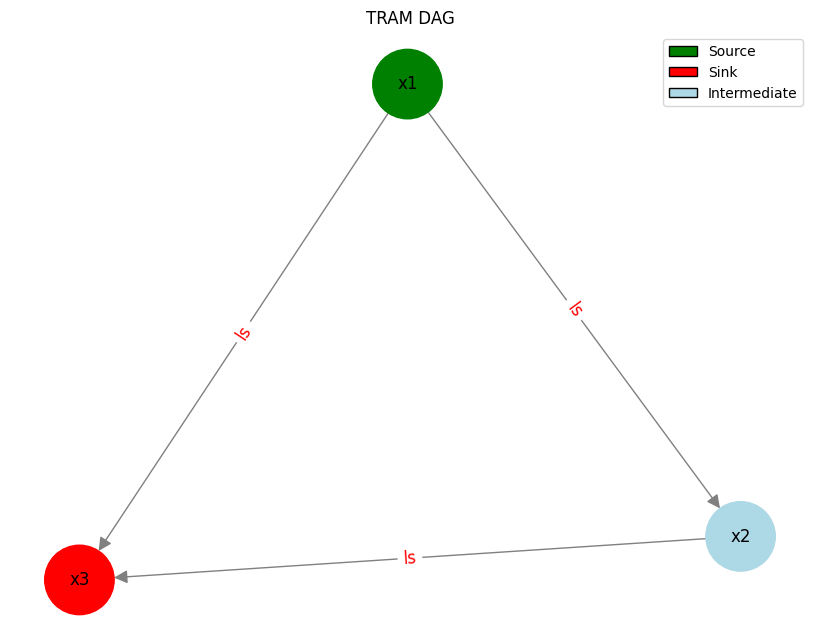

In [ ]:
cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/exp_6_2/configuration.json")
cfg.plot_dag()

# TramDagDataset

In [ ]:
import inspect
from utils.tram_data import GenericDataset
from torch.utils.data import Dataset, DataLoader
class TramDagDataset(Dataset):
    
    #TODO add docstring
    #TODO add verbose and debug , vebose print only infos, debug prints info + debug statements, warnings, errors are always printed
    #TODO add veryfier such that nothing is missing for later training such as experiment name 
    
    DEFAULTS = {
        "batch_size": 32,
        "shuffle": True,
        "num_workers": 4,
        "pin_memory": False,
        "return_intercept_shift": True,
        "debug": False,
        "transform": None,
    }

    def __init__(self):
        """Empty init. Use classmethods like .from_dataframe()."""
        pass

    @classmethod
    def from_dataframe(cls, df, cfg, **kwargs):
        self = cls()
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"[ERROR] df must be a pandas DataFrame, but got {type(df)}")

        # merge defaults with overrides
        settings = dict(cls.DEFAULTS)
        settings.update(kwargs)

        # infer variable name automatically
        callers_locals = inspect.currentframe().f_back.f_locals
        inferred = None
        for var_name, var_val in callers_locals.items():
            if var_val is df:
                inferred = var_name
                break
        df_name = inferred or "dataframe"

        if settings["shuffle"]:
            if any(x in df_name.lower() for x in ["val", "validation", "test"]):
                print(f"[WARNING] DataFrame '{df_name}' looks like a validation/test set → shuffle=True. Are you sure?")

        self.cfg = cfg
        self.df = df.copy()
        self._apply_settings(settings)
        self._build_dataloaders()
        return self

    def compute_scaling(self, df: pd.DataFrame=None, write: bool = True):
        """
        Derive scaling information (min, max, levels) from data USE training data.
        """
        if self.debug:
            print("[DEBUG] Make sure to provide only training data to compute_scaling!")     
        if df is None:
            df = self.df
            if self.debug:
                print("[DEBUG] No DataFrame provided, using internal df.")
        quantiles = df.quantile([0.05, 0.95])
        min_vals = quantiles.loc[0.05]
        max_vals = quantiles.loc[0.95]
        minmax_dict = pd.concat([min_vals, max_vals], axis=1).T.to_dict('list')
        return minmax_dict

    def _apply_settings(self, settings: dict):
        """Apply settings from defaults + overrides."""
        self.batch_size = settings["batch_size"]
        self.shuffle = settings["shuffle"]
        self.num_workers = settings["num_workers"]
        self.pin_memory = settings["pin_memory"]
        self.return_intercept_shift = settings["return_intercept_shift"]
        self.debug = settings["debug"]
        self.transform = settings["transform"]

        # nodes dict
        self.nodes_dict = self.cfg.conf_dict["nodes"]

        # validate dict attributes for all configurable params
        for name, val in {
            "batch_size": self.batch_size,
            "shuffle": self.shuffle,
            "num_workers": self.num_workers,
            "pin_memory": self.pin_memory,
            "return_intercept_shift": self.return_intercept_shift,
            "debug": self.debug,
            "transform": self.transform,
        }.items():
            self._check_keys(name, val)

    def _build_dataloaders(self):
        """Build node-specific dataloaders from df + settings."""
        self.loaders = {}
        for node in self.nodes_dict:
            ds = GenericDataset(
                self.df,
                target_col=node,
                target_nodes=self.nodes_dict,
                transform=self.transform if not isinstance(self.transform, dict) else self.transform[node],
                return_intercept_shift=self.return_intercept_shift if not isinstance(self.return_intercept_shift, dict) else self.return_intercept_shift[node],
                debug=self.debug if not isinstance(self.debug, dict) else self.debug[node],
            )

            batch_size = self.batch_size[node] if isinstance(self.batch_size, dict) else self.batch_size
            shuffle_flag = self.shuffle[node] if isinstance(self.shuffle, dict) else bool(self.shuffle)
            num_workers = self.num_workers[node] if isinstance(self.num_workers, dict) else self.num_workers
            pin_memory = self.pin_memory[node] if isinstance(self.pin_memory, dict) else self.pin_memory

            self.loaders[node] = DataLoader(
                ds,
                batch_size=batch_size,
                shuffle=shuffle_flag,
                num_workers=num_workers,
                pin_memory=pin_memory,
            )

    def _check_keys(self, attr_name, attr_value):
        """Check if dict keys match cfg.conf_dict['nodes'].keys()."""
        if isinstance(attr_value, dict):
            expected_keys = set(self.nodes_dict.keys())
            given_keys = set(attr_value.keys())
            if expected_keys != given_keys:
                raise ValueError(
                    f"[ERROR] the provided attribute '{attr_name}' keys are not same as in cfg.conf_dict['nodes'].keys().\n"
                    f"Expected: {expected_keys}, but got: {given_keys}\n"
                    f"Please provide values for all variables."
                )

    def summary(self):
        print("\n[TramDagDataset Summary]")
        print("=" * 60)

        # ---- DataFrame section ----
        print("\n[DataFrame]")
        print("Shape:", self.df.shape)
        print("\nHead:")
        print(self.df.head())

        print("\nDtypes:")
        print(self.df.dtypes)

        print("\nDescribe:")
        print(self.df.describe(include="all"))

        # ---- Settings per node ----
        print("\n[Node Settings]")
        for node in self.nodes_dict.keys():
            batch_size = self.batch_size[node] if isinstance(self.batch_size, dict) else self.batch_size
            shuffle_flag = self.shuffle[node] if isinstance(self.shuffle, dict) else bool(self.shuffle)
            num_workers = self.num_workers[node] if isinstance(self.num_workers, dict) else self.num_workers
            pin_memory = self.pin_memory[node] if isinstance(self.pin_memory, dict) else self.pin_memory
            rshift = self.return_intercept_shift[node] if isinstance(self.return_intercept_shift, dict) else self.return_intercept_shift
            debug_flag = self.debug[node] if isinstance(self.debug, dict) else self.debug
            transform = self.transform[node] if isinstance(self.transform, dict) else self.transform

            print(
                f" Node '{node}': "
                f"batch_size={batch_size}, "
                f"shuffle={shuffle_flag}, "
                f"num_workers={num_workers}, "
                f"pin_memory={pin_memory}, "
                f"return_intercept_shift={rshift}, "
                f"debug={debug_flag}, "
                f"transform={transform}"
            )
        print("=" * 60 + "\n")

    def __getitem__(self, idx):
        return self.df.iloc[idx].to_dict()

    def __len__(self):
        return len(self.df)


# TramDagModel

In [ ]:
from utils.tram_model_helpers import train_val_loop, get_fully_specified_tram_model 
from utils.tram_data_helpers import create_latent_df_for_full_dag, sample_full_dag
from torch.optim import Adam
import torch
import os


class TramDagModel:
    
    #TODO add docstring
    #TODO add verbose and debug , vebose print only infos, debug prints info + debug statements, warnings, errors are always printed
    # ---- defaults used at construction time ----
    DEFAULTS_CONFIG = {
        "set_initial_weights": True,
        "debug":False,
        
    }

    # ---- defaults used at fit() time ----
    DEFAULTS_FIT = {
        "epochs": 100,
        "train_list": None,
        "callbacks": None,
        "learning_rate": 0.01,
        "device": "auto",
        "optimizers": None,
        "schedulers": None,
        "use_scheduler": False,
        "save_linear_shifts": True,
        "debug":False,
        "verbose": 1,
    }

    def __init__(self):
        """Empty init. Use classmethods like .from_config()."""
        pass

    @classmethod
    def from_config(cls, cfg, **kwargs):
        """
        Build one TramModel per node based on configuration and kwargs.
        Kwargs can be scalars (applied to all nodes) or dicts {node: value}.
        """
        self = cls()
        self.cfg = cfg
        self.nodes_dict = self.cfg.conf_dict["nodes"] 

        # merge defaults with user overrides
        settings = dict(cls.DEFAULTS_CONFIG)
        settings.update(kwargs)

        # initialize settings storage
        self.settings = {k: {} for k in settings.keys()}

        # validate dict-typed args
        for k, v in settings.items():
            if isinstance(v, dict):
                expected = set(self.nodes_dict.keys())
                given = set(v.keys())
                if expected != given:
                    raise ValueError(
                        f"[ERROR] the provided argument '{k}' keys are not same as in cfg.conf_dict['nodes'].keys().\n"
                        f"Expected: {expected}, but got: {given}\n"
                        f"Please provide values for all variables."
                    )

        # build one model per node
        self.models = {}
        for node in self.nodes_dict.keys():
            per_node_kwargs = {}
            for k, v in settings.items():
                resolved = v[node] if isinstance(v, dict) else v
                per_node_kwargs[k] = resolved
                self.settings[k][node] = resolved
            print(f"\n[INFO] Building model for node '{node}' with settings: {per_node_kwargs}")
            self.models[node] = get_fully_specified_tram_model(
                node=node,
                configuration_dict=self.cfg.conf_dict,
                **per_node_kwargs
            )
        return self

    def scaling_from_traindata():
        # create min max dict 
        self.minmax_dict=self.td_train_data.compute_scaling()
        # save minmax dict to the EXPERIMENT_DIR
        try:
            EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
            minmax_path = os.path.join(EXPERIMENT_DIR, "minmax.json")
            with open(minmax_path, 'w') as f:
                json.dump(self.minmax_dict, f)
            if self.debug or self.verbose:
                print(f"[INFO] Saved minmax dict to {minmax_path}")
        


    def fit(self, td_train_data, td_val_data, **kwargs):
        """
        Fit TRAM models for specified nodes.
        All kwargs can be scalar (applied to all nodes) or dict {node: value}.
        """
        # merge defaults with overrides
        settings = dict(self.DEFAULTS_FIT)
        settings.update(kwargs)

        device = torch.device(
            "cuda" if (settings["device"] == "auto" and torch.cuda.is_available()) else settings["device"]
        )
        train_list = settings["train_list"] or list(self.models.keys())

        def _resolve(key, node):
            val = settings[key]
            return val[node] if isinstance(val, dict) else val

        # store resolved settings for this fit
        self.fit_settings = {k: {} for k in settings.keys()}


        self.scaling_from_traindata()


        results = {}
        for node in train_list:
            model = self.models[node]

            # resolve per-node settings
            node_epochs = _resolve("epochs", node)
            node_lr = _resolve("learning_rate", node)
            node_debug = _resolve("debug", node)
            node_save_linear_shifts = _resolve("save_linear_shifts", node)
            node_verbose = _resolve("verbose", node)

            # record them
            self.fit_settings["epochs"][node] = node_epochs
            self.fit_settings["learning_rate"][node] = node_lr
            self.fit_settings["debug"][node] = node_debug
            self.fit_settings["save_linear_shifts"][node] = node_save_linear_shifts
            self.fit_settings["verbose"][node] = node_verbose

            # resolve optimizer
            if settings["optimizers"] and node in settings["optimizers"]:
                optimizer = settings["optimizers"][node]
            else:
                optimizer = Adam(model.parameters(), lr=node_lr)
            self.fit_settings["optimizers"][node] = optimizer

            # resolve scheduler
            if settings["schedulers"] and node in settings["schedulers"]:
                scheduler = settings["schedulers"][node]
            else:
                scheduler = None
            self.fit_settings["schedulers"][node] = scheduler

            # grab loaders
            train_loader = td_train_data.loaders[node]
            val_loader = td_val_data.loaders[node]

            # min max for scaling
            min_vals = torch.tensor(self.minmax_dict[node][0], dtype=torch.float32, device=device)
            max_vals = torch.tensor(self.minmax_dict[node][1], dtype=torch.float32, device=device)
            min_max = torch.stack([min_vals, max_vals], dim=0)
            
            try:
                EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
                NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")
                # print(f"[INFO] NODE_DIR : {NODE_DIR}")
            except Exception:
                NODE_DIR = os.path.join("models", node)
                print("[WARNING] No log directory specified in config, saving to default location.")
                
            os.makedirs(NODE_DIR, exist_ok=True)
            self.fit_settings["NODE_DIR"] = {node: NODE_DIR}

            if node_verbose:
                print(f"\n[INFO] Training node '{node}' for {node_epochs} epochs on {device}")

            history = train_val_loop(
                node=node,
                target_nodes=self.nodes_dict,
                NODE_DIR=NODE_DIR,
                tram_model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                epochs=node_epochs,
                optimizer=optimizer,
                use_scheduler=(scheduler is not None),
                scheduler=scheduler,
                save_linear_shifts=node_save_linear_shifts,
                verbose=node_verbose,
                device=device,
                debug=node_debug,
                min_max=min_max
            )
            results[node] = history

        return results


    def get_latent(self, df, verbose=False):
            """
            Compute latent representations for the full DAG.

            Parameters
            ----------
            df : pd.DataFrame
                Input dataframe with columns for each node.
            verbose : bool, optional
                If True, prints [INFO] statements during processing.

            Returns
            -------
            pd.DataFrame
                DataFrame with latent variables for each node. Columns are
                [node, f"{node}_U"] for each continuous target.
            """
            try:
                EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
            except KeyError:
                raise ValueError(
                    "[ERROR] Missing 'EXPERIMENT_DIR' in cfg.conf_dict['PATHS']. "
                    "Latent extraction requires trained model checkpoints."
                )

            all_latents_df = create_latent_df_for_full_dag(
                configuration_dict=self.cfg.conf_dict,
                EXPERIMENT_DIR=EXPERIMENT_DIR,
                df=df,
                verbose=verbose,
            )

            return all_latents_df

    def sample(
        self,
        do_interventions: dict = None,
        predefined_latent_samples_df: pd.DataFrame = None,
        number_of_samples: int = 10_000,
        batch_size: int = 32,
        delete_all_previously_sampled: bool = True,
        verbose: bool = False,
        debug: bool = False,
    ):
        """
        Sample from the DAG using trained TRAM models.

        Parameters
        ----------
        do_interventions : dict, optional
            Mapping of node names to fixed values. Example: {'x1': 1.0}.
        predefined_latent_samples_df : pd.DataFrame, optional
            DataFrame with predefined latent U's. Must contain columns "{node}_U".
        number_of_samples : int, default=10_000
            Number of samples to draw if no predefined latents are given.
        batch_size : int, default=32
            Batch size for DataLoader evaluation during sampling.
        delete_all_previously_sampled : bool, default=True
            Whether to remove existing sampled.pt/latents.pt files before resampling.
        verbose : bool, default=True
            Print high-level progress messages ([INFO]).
        debug : bool, default=False
            Print detailed debug messages ([DEBUG]) in addition to [INFO].

        Returns
        -------
        sampled_by_node : dict
            Mapping {node: tensor of sampled values}.
        latents_by_node : dict
            Mapping {node: tensor of latent U's used}.
        """
        try:
            EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
        except KeyError:
            raise ValueError(
                "[ERROR] Missing 'EXPERIMENT_DIR' in cfg.conf_dict['PATHS']. "
                "Sampling requires trained model checkpoints."
            )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        sampled_by_node, latents_by_node = sample_full_dag(
            configuration_dict=self.cfg.conf_dict,
            EXPERIMENT_DIR=EXPERIMENT_DIR,
            device=device,
            do_interventions=do_interventions or {},
            predefined_latent_samples_df=predefined_latent_samples_df,
            number_of_samples=number_of_samples,
            batch_size=batch_size,
            delete_all_previously_sampled=delete_all_previously_sampled,
            verbose=verbose,
            debug=debug,
        )
        return sampled_by_node, latents_by_node

    def summary(self):
        print("\n[TramDagModel Summary]")
        print("=" * 60)
        for node, model in self.models.items():
            print(f" Node '{node}': {model.__class__.__name__}")
            for k, v in self.settings.items():
                if node in v:
                    print(f"   - {k}: {v[node]}")
        print("=" * 60 + "\n")


# TESTING API

#### Data (pandas dataframe)

In [29]:
train_df=pd.read_csv('/home/bule/TramDag/dev_experiment_logs/exp_6_2/exp_6_2_train.csv')
val_df=pd.read_csv('/home/bule/TramDag/dev_experiment_logs/exp_6_2/exp_6_2_val.csv')

# splits 

In [35]:

quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]


minmax_dict = pd.concat([min_vals, max_vals], axis=1).T.to_dict('list')
minmax_dict

{'x1': [0.12157964485414735, 0.794303998711493],
 'x2': [-0.8069206639187695, 0.418925659248077],
 'x3': [0.0, 3.0]}

In [32]:
max_vals

x1    0.794304
x2    0.418926
x3    3.000000
Name: 0.95, dtype: float64

In [33]:
min_vals

x1    0.121580
x2   -0.806921
x3    0.000000
Name: 0.05, dtype: float64

####  Configuration
create  a config file e.g. with create_config.ipynb
load the file and compute necessary values on the cfg based on data

In [ ]:
# TODO move scaling to TramDagdataset , save min max to experiment dir under eg /x1 scaling
# TODO write WARNING if ordinal  is provided and levels dict is not proived , either calculate directly from data or add manually to configuration dict
# TODO , .show_graph()


cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/exp_6_2/configuration.json")
cfg.compute_scaling(train_df) # computes min max levels from training data and writes to cfg

[INFO] Make sure to provide only training data to compute_scaling!
[INFO] Configuration with updated scaling saved to /home/bule/TramDag/dev_experiment_logs/exp_6_2/configuration.json


create a dedicated TramDagDataset from the pandas dataframe and the config file

In [7]:
td_train_data=TramDagDataset.from_dataframe(train_df,cfg)  
td_val_data=TramDagDataset.from_dataframe(val_df,cfg,shuffle=False)

create a TramdagModel from the Config file (optionally use COLR POLR as startign values)

In [9]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False) 


[INFO] Building model for node 'x1' with settings: {'set_initial_weights': False, 'debug': False}

[INFO] Building model for node 'x2' with settings: {'set_initial_weights': False, 'debug': False}

[INFO] Building model for node 'x3' with settings: {'set_initial_weights': False, 'debug': False}


fit the model on the data

In [ ]:
td_model.fit( td_train_data, td_val_data, epochs=1)


[INFO] Training node 'x1' for 1 epochs on cuda
Existing model found. Loading weights and history...

[INFO] Training node 'x2' for 1 epochs on cuda
Existing model found. Loading weights and history...

[INFO] Training node 'x3' for 1 epochs on cuda
Existing model found. Loading weights and history...


{'x1': None, 'x2': None, 'x3': None}

get latents from a dateset marked as _U

In [9]:
latents_df = td_model.get_latent(train_df, verbose=False)


[INFO] Skipping node 'x3' (ordinal targets not yet supported).
[INFO] Final latent DataFrame shape: (80000, 4)


sample from the whole graph , intervene or use predefined latents

In [10]:
td_model.sample()

Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:20<00:00, 483.41it/s]


----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:20<00:00, 499.26it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


({'x1': tensor([0.3483, 0.0947, 0.7013,  ..., 0.7456, 0.4402, 0.7402]),
  'x2': tensor([-0.7723, -0.4455, -0.6446,  ..., -0.5838,  0.0118, -0.0776]),
  'x3': tensor([3, 1, 1,  ..., 1, 1, 1])},
 {'x1': tensor([-0.3249, -3.5280,  0.5531,  ...,  1.4165, -0.0556,  1.2757]),
  'x2': tensor([-3.1587, -2.0288, -1.7538,  ..., -1.4134,  0.9523,  1.1017]),
  'x3': tensor([0.1774, 0.6739, 6.4358,  ..., 2.4577, 0.5640, 2.2817])})

# TODO

In [ ]:
cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/exp_6_2/configuration.json")
td_model = TramDagModel.from_config(cfg, set_initial_weights=False) 

In [ ]:
# laod model 
td_model =TramDagModel.load_from_directory("/home/bule/TramDag/dev_experiment_logs/exp_6_2/")

In [ ]:
td_model.load() # load exisit trained models 

In [ ]:
hist=td_model.history() # # mo show_training_history(node_list,EXPERIMENT_DIR)

In [ ]:
td_model.show_hdag_for_source_nodes()#show_hdag_for_source_nodes(configuration_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton

In [ ]:
td_model.inspect_trafo_standart_logistic()
#inspect_trafo_standart_logistic(configuration_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)